In [1]:
import pandas as pd
import numpy as np
from scipy.stats.contingency import odds_ratio
import forestplot as fp
from scipy.stats import fisher_exact

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [3]:
case_controls_file = "/data6/deepro/ukb_bmi/1_data_processing/data/british/case_controls.csv"

study_genes_list_files = [
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/akbari_2021/data/akbari_genes.list",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/turcot_2018/data/turcot_genes.list"
    ]

combo_files = [
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/combo2.csv",
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/combo3.csv"
]

genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"

In [4]:
case_cont_df = pd.read_csv(case_controls_file)

In [5]:
case_samples = set(case_cont_df.loc[case_cont_df.Output_BMI==1, "Sample_Name"].astype("str").values)
control_samples = set(case_cont_df.loc[case_cont_df.Output_BMI==0, "Sample_Name"].astype("str").values)

In [6]:
def get_gene_set(gene_file):
    with open(gene_file, "r") as f:
        genes = set([g.strip() for g in f.readlines()])
    return genes

In [7]:
study_genes = [get_gene_set(gf) for gf in study_genes_list_files]
combo_dfs = [pd.read_csv(cf) for cf in combo_files]

In [8]:
genotype_df = pd.read_csv(genotype_file)

In [9]:
def create_contingency_tables_genes(genotype_df, genes, case_samples, control_samples):
    all_gene_samples = set(",".join(genotype_df.loc[genotype_df.gene.isin(genes)].samples.values).split(","))
    all_gene_case_samples = case_samples.intersection(all_gene_samples)
    all_nongene_case_samples = case_samples.difference(all_gene_samples)
    all_gene_cont_samples = control_samples.intersection(all_gene_samples)
    all_nongene_cont_samples = control_samples.difference(all_gene_samples)
    contingency_table = np.array([[len(all_gene_case_samples), len(all_nongene_case_samples)], [len(all_gene_cont_samples), len(all_nongene_cont_samples)]])
    return contingency_table

def create_contingency_tables_combos(combo_df, case_samples, control_samples):
    all_combo_samples = set("|".join(combo_df.Case_Samples.values).split("|")).union(set("|".join(combo_df.Control_Samples.dropna().values).split("|")))
    all_combo_case_samples = case_samples.intersection(all_combo_samples)
    all_noncombo_case_samples = case_samples.difference(all_combo_samples)
    all_combo_cont_samples = control_samples.intersection(all_combo_samples)
    all_noncombo_cont_samples = control_samples.difference(all_combo_samples)
    contingency_table = np.array([[len(all_combo_case_samples), len(all_noncombo_case_samples)], [len(all_combo_cont_samples), len(all_noncombo_cont_samples)]])
    return contingency_table



In [10]:
cont_tables_study = [create_contingency_tables_genes(genotype_df, sg, case_samples, control_samples) for sg in study_genes]
cont_tables_combos = [create_contingency_tables_combos(cdf, case_samples, control_samples) for cdf in combo_dfs]

In [11]:
odds_ratios_all = [odds_ratio(ct) for ct in cont_tables_study + cont_tables_combos]

In [12]:
fishers_all = [fisher_exact(ct) for ct in cont_tables_study + cont_tables_combos]

In [13]:
data_dict = {"study_type": [], "odds_ratio": [], "ci_low": [], "ci_high": [], "pvalue": []}

for or_study, fe_study, st in zip(odds_ratios_all, fishers_all, ["Akbari et. al.", "Turcot et. al. ", "Digenic Combinations", "Trigenic Combinations"]):
    data_dict["study_type"].append(st)
    data_dict["odds_ratio"].append(or_study.statistic)
    cil, cih = or_study.confidence_interval(confidence_level=0.95)
    data_dict["ci_low"].append(cil)
    data_dict["ci_high"].append(cih)
    data_dict["pvalue"].append(fe_study.pvalue)

df = pd.DataFrame(data_dict)

In [14]:
df["study_type_group"] = ["RVAS", "RVAS", "RareComb", "RareComb"]

In [15]:
df

,study_type,odds_ratio,ci_low,ci_high,pvalue,study_type_group
0,Akbari et. al.,1.149526,1.096099,1.205471,8.644771e-09,RVAS
1,Turcot et. al.,1.063093,1.012801,1.115779,1.312199e-02,RVAS
2,Digenic Combinations,10.498392,9.698086,11.377889,0.000000e+00,RareComb
3,Trigenic Combinations,37.202553,29.427868,47.692341,0.000000e+00,RareComb


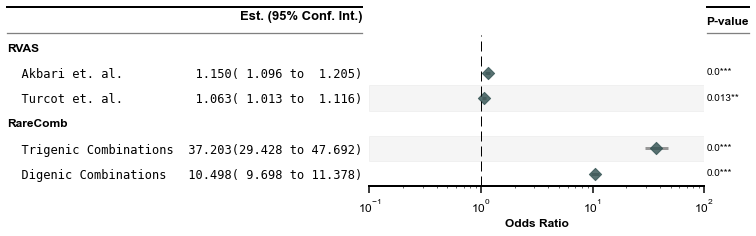

In [16]:
fig = fp.forestplot(df,  # the dataframe with results data
              estimate="odds_ratio",  # col containing estimated effect size 
              ll="ci_low", hl="ci_high",
              pval="pvalue",
              decimal_precision=3,
              varlabel="study_type",  # column containing variable label
              groupvar="study_type_group",  # Add variable groupings
              color_alt_rows=True,
              table=True,
              annote=["est_ci"],
              annoteheaders=["Est. (95% Conf. Int.)"],
              # group ordering
              group_order=["RVAS", "RareComb"],
              sort=True, # sort in ascending order (sorts within group if group is specified)
              logscale=True, 
              ylabel="Est. (95% Conf. Int.)",  # y-label title
              xlabel="Odds Ratio",  # x-label title
              xticks=[0.1, 1, 10, 100],
              # xticks=[-5, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50],
              figsize=(6, 3 ),
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 75,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "k",  # gray color for x-reference line
                 "xline": 1,
                 "xlinewidth": 1,
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 "lw": 3,
                }       
              )


In [18]:
save_pdf("../data/effect_sizes/british/figures/odr.pdf", fig.figure)